# Association Analysis of Filipino Cuisine Ingredients


## Data loading and preview


### Read JSON files


In [ ]:
import json
import os


def load_recipes(path="data/recipes"):
    """Combines all recipe data into a single list."""
    files = [file for file in os.listdir(path)]

    recipes = []
    for file in files:
        file_path = os.path.join(path, file)
        with open(file_path, encoding="utf-8") as f:
            recipe_data = json.load(f)
            recipes.extend(recipe_data)

    return recipes


recipes = load_recipes()
recipes[0]

### Convert JSON to DataFrame


In [ ]:
import pandas as pd


recipe_df = pd.DataFrame(recipes)
recipe_df.head()

In [ ]:
recipe_df.info()

### Display some statistics


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


def plot_ingredient_count_distribution(ingredient_series, figsize=(8, 3)):
    """Plots the distribution of the number of ingredients in recipes."""
    counts = ingredient_series.dropna().apply(len)
    plt.figure(figsize=figsize)
    sns.histplot(counts, kde=True, binwidth=1)
    plt.title(f"Number of ingredients in {len(counts)} recipes")
    plt.xlabel("Number of ingredients")
    plt.ylabel("Number of recipes")
    plt.tight_layout()
    plt.show()


def plot_common_ingredients(
    ingredient_series, n=30, most_common=True, figsize=(8, 7)
):
    """Plots the most or least common ingredients."""
    all_ingredients = ingredient_series.dropna().explode()
    ingredient_counts = all_ingredients.value_counts()

    if most_common:
        top_n_ingredients = ingredient_counts.head(n)
    else:
        top_n_ingredients = ingredient_counts.tail(n)

    ylabels = [
        f"{i[:20]:>20}{'...' if len(i) > 20 else ''}"
        for i in top_n_ingredients.index
    ]
    plt.figure(figsize=figsize)
    sns.barplot(x=top_n_ingredients.values, y=ylabels)
    indicator = "Most" if most_common else "Least"
    plt.title(f"Top {n} {indicator} Common Ingredients")
    plt.xlabel("Number of Recipes")
    plt.ylabel("Ingredient")
    plt.tight_layout()
    plt.show()


plot_ingredient_count_distribution(recipe_df.ingredients)
plot_common_ingredients(recipe_df.ingredients, n=30, most_common=True)

## Preprocessing


### Step 0. Remove recipes with no ingredients


In [ ]:
def drop_empty_ingredients(recipe_df, column="ingredients"):
    """Drops rows with empty ingredients."""
    new_df = recipe_df.dropna(subset=[column])
    print(f"Dropped {recipe_df.shape[0] - new_df.shape[0]} rows.")
    return new_df


recipe_df = drop_empty_ingredients(recipe_df)

In [ ]:
def save_ingredients(ingredient_series, path):
    """Saves the ingredients to a TXT file."""
    os.makedirs(os.path.dirname(path), exist_ok=True)

    all_ingredients = ingredient_series.dropna().explode()
    data = sorted(all_ingredients.unique().astype(str))

    with open(path, "w", encoding="utf-8") as file:
        for ingredient in data:
            file.write(f"{ingredient.strip()}\n")


save_ingredients(
    recipe_df.ingredients,
    path="data/preprocess_output/0_raw.txt",
)

### Step 1. Clean ingredient format


In [ ]:
import re

from tqdm import tqdm

tqdm.pandas()


def remove_parentheses(ingredient):
    """Removes parentheses and content from ingredient strings."""
    return re.sub(r" ?\([^)]+\)", "", ingredient)


def select_first_option(ingredient):
    """Selects the first option in a string with multiple options."""
    return ingredient.split(" or ")[0]


def clean_ingredient(ingredient):
    """Cleans an ingredient string."""
    ingredient = remove_parentheses(ingredient)
    ingredient = select_first_option(ingredient)
    return ingredient.lower().strip()


recipe_df["cleaned"] = recipe_df.ingredients.progress_apply(
    lambda x: [cleaned for i in x if (cleaned := clean_ingredient(i))]
)

In [ ]:
save_ingredients(
    recipe_df.cleaned,
    path="data/preprocess_output/1_cleaned.txt",
)

### Step 2. Lemmatize words and remove non-ingredient words


In [ ]:
import spacy

nlp = spacy.load("en_core_web_lg")


def correct_noun_pos_tags(token):
    """Corrects the POS tags of specific tokens."""
    outliers = ["cauliflower", "baking"]
    if token.text in outliers:
        token.pos_ = "NOUN"
    return token


def lemmatize_nouns(ingredient):
    """Lemmatizes nouns in an ingredient string."""
    doc = nlp(ingredient)
    lemmas = []
    for token in doc:
        token = correct_noun_pos_tags(token)
        if (
            token.is_alpha
            and not token.is_stop
            and token.pos_ in ["NOUN", "PROPN"]
        ):
            lemmas.append(token.lemma_)
    return " ".join(lemmas)


recipe_df["lemmatized"] = recipe_df.cleaned.progress_apply(
    lambda x: [lemmatized for i in x if (lemmatized := lemmatize_nouns(i))]
)

In [ ]:
save_ingredients(
    recipe_df.lemmatized,
    path="data/preprocess_output/2_lemmatized.txt",
)

### Step 3. Remove stop words related to culinary


In [ ]:
input_file = "data/preprocess_input/stopwords.txt"
with open(input_file, encoding="utf-8") as file:
    stopwords = file.read().splitlines()


def filter_stopwords(text):
    """Filter out stopwords from a string."""
    words = []
    for word in text.split():
        if word not in stopwords:
            words.append(word)
    return " ".join(words)


recipe_df["filtered"] = recipe_df.lemmatized.progress_apply(
    lambda x: [filtered for i in x if (filtered := filter_stopwords(i))]
)

In [ ]:
save_ingredients(
    recipe_df.filtered,
    path="data/preprocess_output/3_filtered.txt",
)

### Step 4. Standardize ingredient names at word level


In [ ]:
input_file = "data/preprocess_input/thesaurus.json"
with open(input_file, encoding="utf-8") as file:
    thesaurus = json.load(file)


def standardize_at_phrase_level(ingredient):
    """Replace words in an ingredient with standard names."""
    words = []
    for word in ingredient.split():
        words.append(thesaurus.get(word, word))
    return " ".join(words)


recipe_df["standardized_word"] = recipe_df.filtered.progress_apply(
    lambda x: [
        common_name
        for i in x
        if (common_name := standardize_at_phrase_level(i))
    ]
)

In [ ]:
save_ingredients(
    recipe_df.standardized_word,
    path="data/preprocess_output/4_standardized_word.txt",
)

### Step 5. Remove duplicate terms


In [ ]:
def remove_duplicates(text):
    """Remove duplicate terms while preserving order."""
    seen = set()
    unique = []
    for word in text.split():
        if word not in seen:
            unique.append(word)
            seen.add(word)
    return " ".join(unique)


recipe_df["unique"] = recipe_df.standardized_word.progress_apply(
    lambda x: [unique for i in x if (unique := remove_duplicates(i))]
)

In [ ]:
save_ingredients(
    recipe_df.unique,
    path="data/preprocess_output/5_unique.txt",
)

### Step 6. Standardize ingredient names at phrase level


In [ ]:
def standardize_at_phrase_level(ingredient):
    """Replace the whole ingredient string with a standard name."""
    return thesaurus.get(ingredient, ingredient)


recipe_df["standardized_phrase"] = recipe_df.unique.progress_apply(
    lambda x: [
        standardized
        for i in x
        if (standardized := standardize_at_phrase_level(i))
    ]
)

In [ ]:
save_ingredients(
    recipe_df.standardized_phrase,
    path="data/preprocess_output/6_standardized_phrase.txt",
)

### Step 7. Break down ingredients into basic components


In [ ]:
input_file = "data/preprocess_input/components.json"
with open(input_file, encoding="utf8") as file:
    ingredient_components = json.load(file)


def break_down_ingredient(ingredient):
    """Breaks down an ingredient into its components."""
    components = ingredient_components.get(ingredient, ingredient)
    if isinstance(components, str):
        return [components]
    return components


recipe_df["components"] = recipe_df.standardized_phrase.progress_apply(
    lambda x: [component for i in x for component in break_down_ingredient(i)]
)

In [ ]:
save_ingredients(
    recipe_df.components,
    path="data/preprocess_output/7_components.txt",
)

In [ ]:
plot_ingredient_count_distribution(recipe_df.components)
plot_common_ingredients(recipe_df.components)

### Save preprocessed data


In [ ]:
recipe_df.head()

In [ ]:
recipe_df.to_csv(
    "data/preprocessed_recipes.csv",
    index=False,
    columns=["name", "components"],
)

## Data Transformation


### Convert DataFrame to one-hot encoded format


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(recipe_df.components)
one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)

one_hot_df.head()

In [ ]:
one_hot_df.to_csv(
    "data/one_hot_encoded_recipes.csv",
    index=False,
)

## Association Analysis


In [1]:
import pandas as pd

one_hot_df = pd.read_csv("data/one_hot_encoded_recipes.csv")
one_hot_df = one_hot_df.astype(bool)
one_hot_df.head()

,achiote,alcohol,amaranth,anchovy,anise,annatto,apple,artichoke,arugula,asparagus,...,vegetable,vinegar,wasabi,whip,wholemeal,worchestershire sauce,wrapper,yam,yeast,yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Find frequent itemsets


In [2]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(
    one_hot_df,
    min_support=0.05, #  Lower this value to get more frequent itemsets
    use_colnames=True,
)

frequent_itemsets.head()

,support,itemsets
0,0.051591,(baking)
1,0.080082,(bay leaf)
2,0.095996,(bean)
3,0.105749,(beef)
4,0.093686,(bell pepper)


### Generate association rules


In [3]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.5,
)

rules[["antecedents", "consequents", "support", "confidence", "lift"]].head()

,antecedents,consequents,support,confidence,lift
0,(bay leaf),(oil),0.064938,0.810897,1.334709
1,(bay leaf),(onion),0.054415,0.679487,1.214907
2,(bay leaf),(pepper),0.054928,0.685897,2.035230
3,(bean),(oil),0.069045,0.719251,1.183863
4,(bean),(onion),0.081366,0.847594,1.515477


### Filtering and exploring rules


In [4]:
filtered_rules = rules[(rules["lift"] >= 1.2) & (rules["confidence"] >= 0.6)]
filtered_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(bay leaf),(oil),0.080082,0.607546,0.064938,0.810897,1.334709,0.016285,2.075349,0.272604
1,(bay leaf),(onion),0.080082,0.559292,0.054415,0.679487,1.214907,0.009626,1.375010,0.192291
2,(bay leaf),(pepper),0.080082,0.337012,0.054928,0.685897,2.035230,0.027939,2.110736,0.552935
4,(bean),(onion),0.095996,0.559292,0.081366,0.847594,1.515477,0.027676,2.891666,0.376261
5,(beef),(oil),0.105749,0.607546,0.077259,0.730583,1.202514,0.013011,1.456675,0.188324


### Save association rules 

In [5]:
# Save association rules into CSV
filtered_rules.to_csv(
    "data/association_rules.csv",
    index=False,
    columns=["antecedents", "consequents"],
)

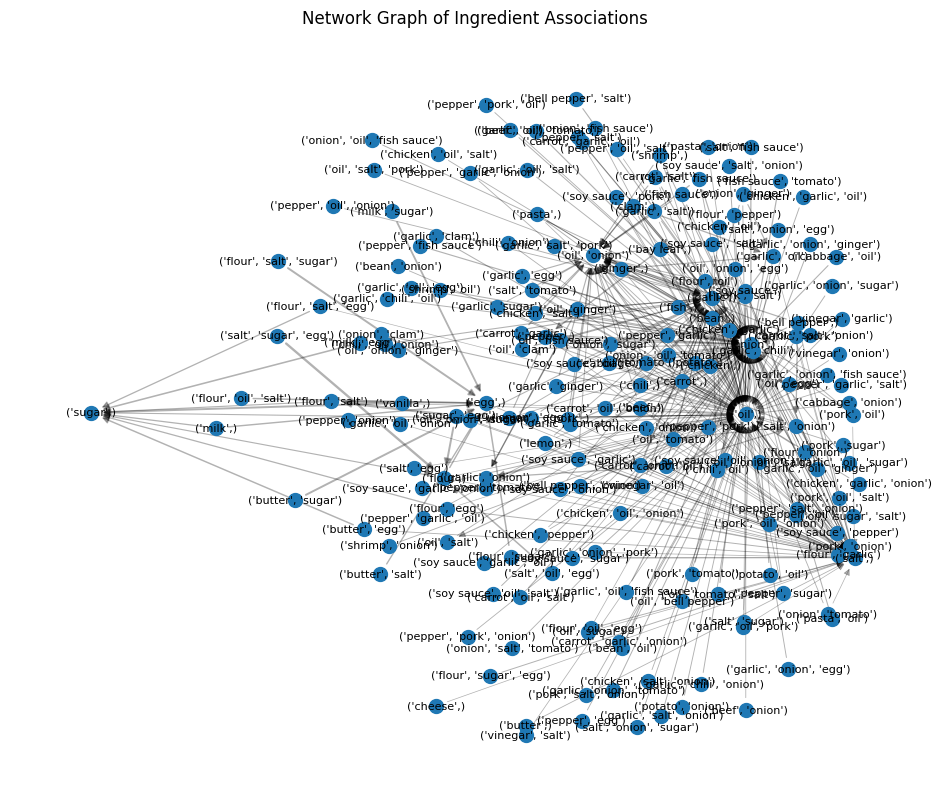

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph from the association rules
G = nx.DiGraph()

# Add edges between antecedents and consequents
for _, row in rules.iterrows():
    G.add_edge(
        str(tuple(row["antecedents"])),
        str(tuple(row["consequents"])),
        weight=row["lift"],
    )

# Draw the network
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5)  # k regulates the distance between nodes
edges = nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.3,
    width=[float(d["weight"]) * 0.5 for (u, v, d) in G.edges(data=True)],
)
nodes = nx.draw_networkx_nodes(G, pos, node_size=100)
labels = nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Network Graph of Ingredient Associations")
plt.axis("off")
plt.show()